- For a \( 10^{-5} \) difference: \( \epsilon = 10^{-5} \) → **Multiplier** = \( 1.00001 \)
- For a \( 10^{-10} \) difference: \( \epsilon = 10^{-10} \) → **Multiplier** = \( 1.0000000001 \)
- For a \( 10^{-15} \) difference: \( \epsilon = 10^{-15} \) → **Multiplier** = \( 1.000000000000001 \)

In [4]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 500  

In [100]:
def run_meander_simulation(freq_multiplier, amplitude, multiplier):
    nit = 1001                  # number of iterations
    W = 100.0                    # channel width (m)
    D = 1.0                      # channel depth (m)
    depths = D * np.ones((nit,))  # channel depths for different iterations
    pad = 50                # padding (number of nodepoints along centerline)
    deltas = 100.0                # sampling distance along centerline
    Cfs = 0.006 * np.ones((nit,)) # dimensionless Chezy friction factor
    crdist = 10*multiplier* W               # threshold distance at which cutoffs occur
    kl = 500.0/(365*24*60*60.0)   # migration rate constant (m/s)
    kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
    dt = 0.1*0.5*365*24*60*60.0     # time step (s)
    dens = 1000                  # density of water (kg/m3)
    saved_ts = 1                # which time steps will be saved
    n_bends = 1                 # approximate number of bends you want to model
    Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
    t1 = 0                    # time step when incision starts
    t2 = 0                    # time step when lateral migration starts
    t3 = 0                    # time step when aggradation starts
    aggr_factor = 2e-19         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)
    x_initial = np.linspace(0.1, 20000, 3000)
    y_initial = (amplitude * 100) * np.sin(freq_multiplier * np.pi * x_initial / 1000.0)
    z_initial = np.zeros_like(x_initial)
    ch = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist, depths, Cfs, kl, kv, dt, dens, t1, t2, t3, aggr_factor)
    return chb

In [ ]:
ensemble_size = 1
all_spreads_over_time = []

for run_idx in range(ensemble_size):
    freq_multiplier = np.random.uniform(0.5, 2.0)
    amplitude       = np.random.uniform(0.5, 5.0)
    
    chb = run_meander_simulation(freq_multiplier, amplitude, 1)
    spreads_t = []
    # For each saved channel in the belt, measure bounding box
    for ch in chb.channels:
        x, y = ch.x, ch.y
        spread = np.ptp(y)  # just an example: y-range
        spreads_t.append(spread)
    all_spreads_over_time.append(spreads_t)

100%|██████████| 1001/1001 [00:04<00:00, 217.28it/s]


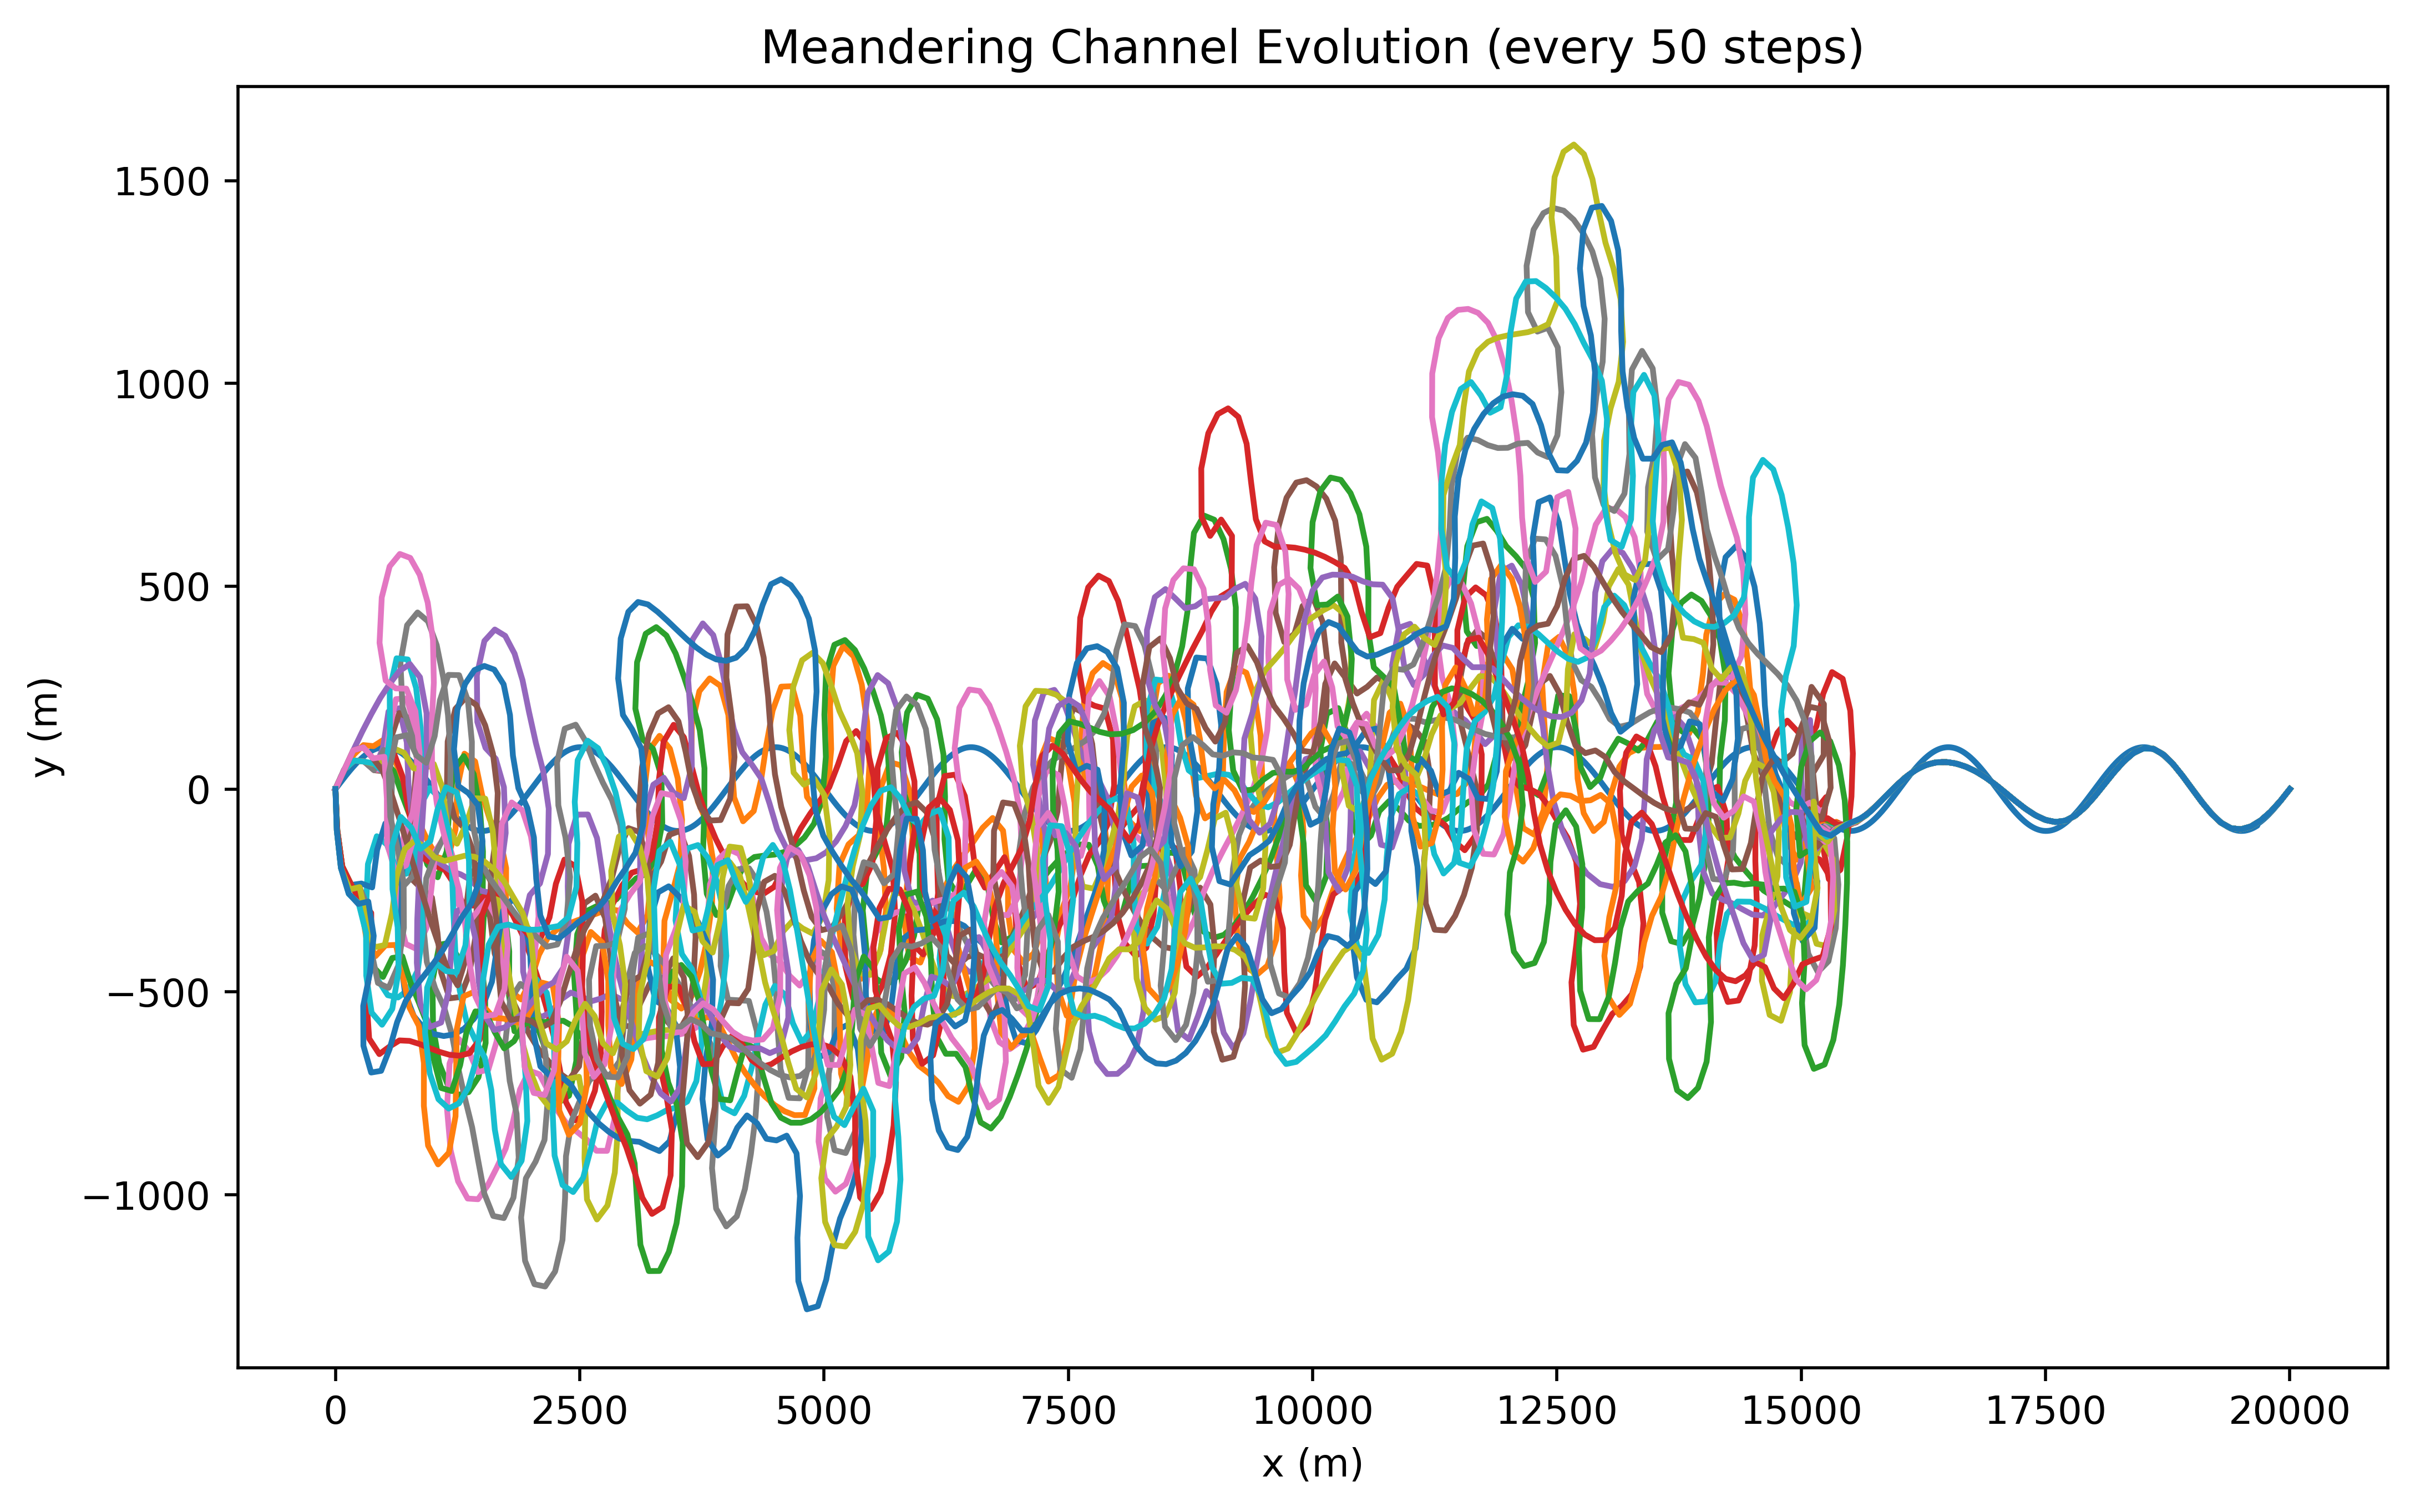

In [101]:
chb = run_meander_simulation(freq_multiplier=1.0, amplitude=1.0, multiplier=1)

# Plot the channel geometry at selected timesteps
plt.figure(figsize=(10, 6))
timesteps_to_plot = range(0, len(chb.channels), 50)  # e.g., every 50 steps

for i in timesteps_to_plot:
    channel = chb.channels[i]
    x, y = channel.x, channel.y
    plt.plot(x, y, label=f"Step {i}")

plt.title("Meandering Channel Evolution (every 50 steps)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

In [112]:
ensemble_size = 1
all_spreads_over_time = []

for run_idx in range(ensemble_size):
    freq_multiplier = np.random.uniform(0.5, 2.0)
    amplitude       = np.random.uniform(0.5, 5.0)
    
    chb = run_meander_simulation(freq_multiplier, amplitude, 1)
    spreads_t = []
    # For each saved channel in the belt, measure bounding box
    for ch in chb.channels:
        x, y = ch.x, ch.y
        spread = np.ptp(y)  # just an example: y-range
        spreads_t.append(spread)
    all_spreads_over_time.append(spreads_t)



# Convert to array: shape (ensemble_size, n_timesteps)
all_spreads_over_time = np.array([np.pad(s, (0,1001-len(s)), 'edge')  # ensure uniform shape
                                  for s in all_spreads_over_time])

# Look at the standard deviation across runs at each time step
time_spread_mean  = np.mean(all_spreads_over_time, axis=0)
time_spread_std   = np.std(all_spreads_over_time, axis=0)


plt.plot(range(len(time_spread_mean)), time_spread_mean, 'b-', label='Mean spread')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Spread in y (m)')
plt.ylim([0,5000])
plt.title('Ensemble Spread Over Time')
plt.show()


100%|██████████| 1001/1001 [00:04<00:00, 212.77it/s]


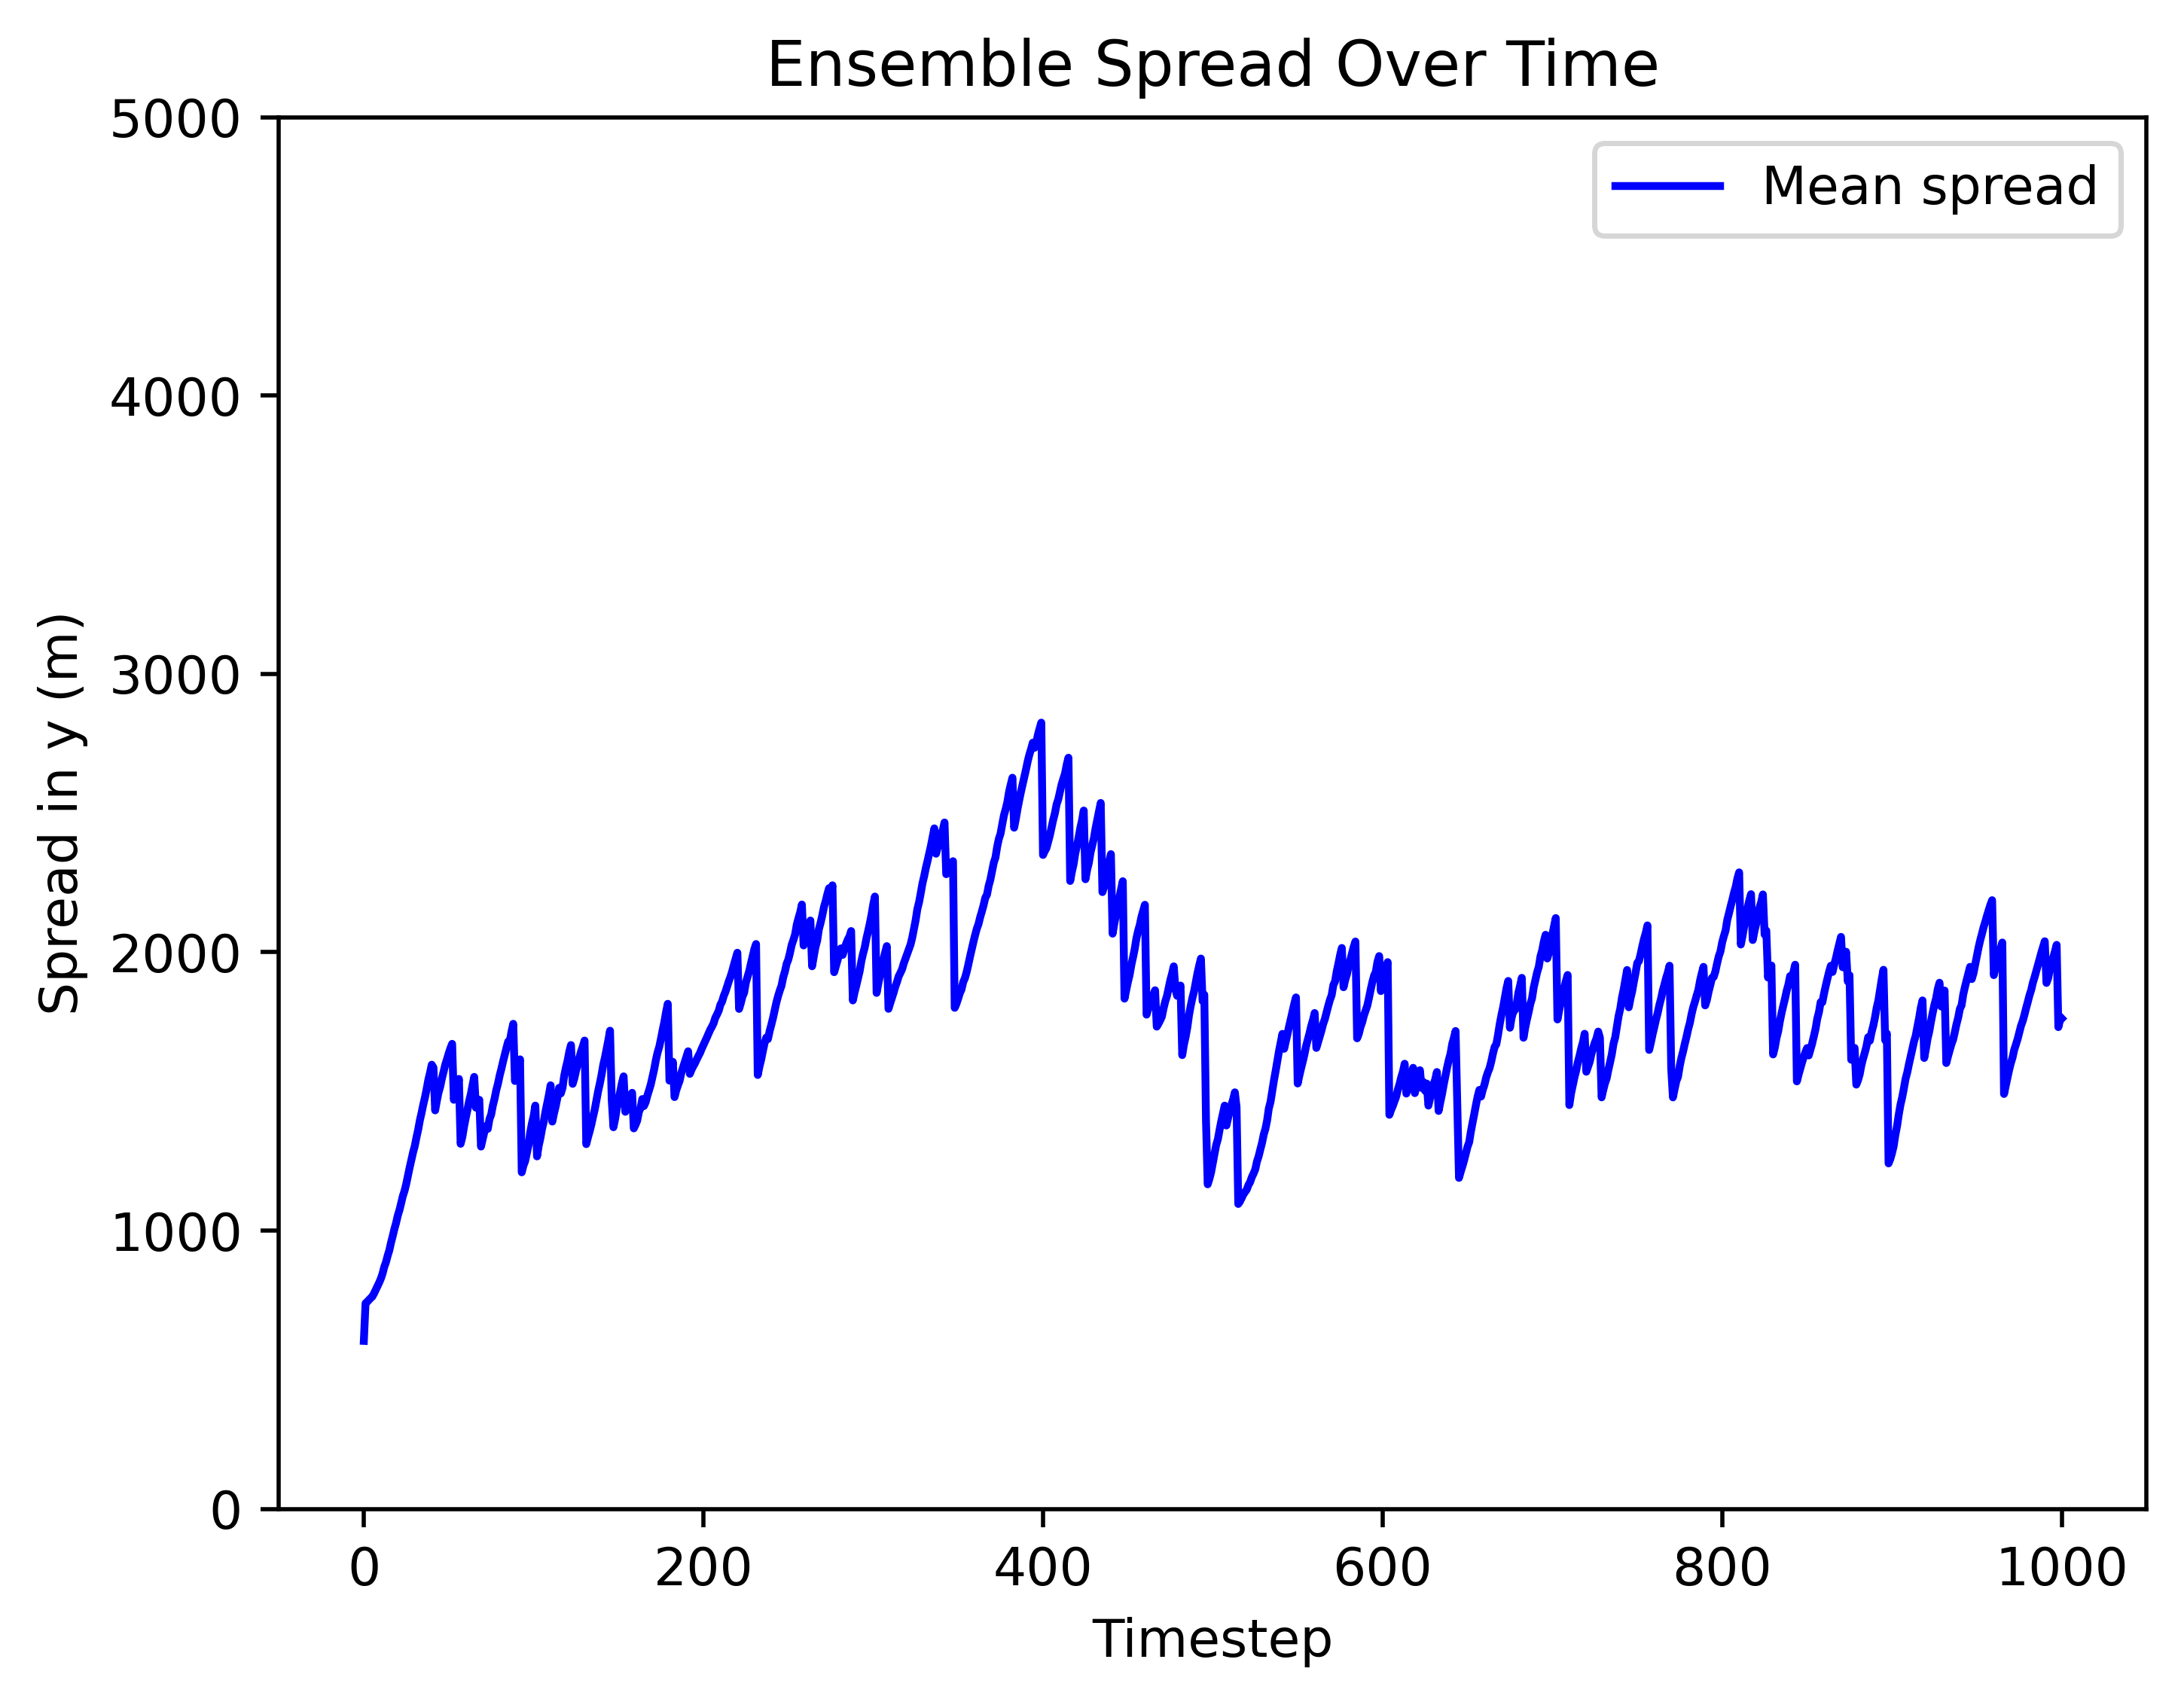

In [113]:


# Convert to array: shape (ensemble_size, n_timesteps)
all_spreads_over_time = np.array([np.pad(s, (0,1001-len(s)), 'edge')  # ensure uniform shape
                                  for s in all_spreads_over_time])

# Look at the standard deviation across runs at each time step
time_spread_mean  = np.mean(all_spreads_over_time, axis=0)
time_spread_std   = np.std(all_spreads_over_time, axis=0)


plt.plot(range(len(time_spread_mean)), time_spread_mean, 'b-', label='Mean spread')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Spread in y (m)')
plt.ylim([0,5000])
plt.title('Ensemble Spread Over Time')
plt.show()


In [67]:
def resample_channel(x, y, num_points=10000):
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)  
    s = np.concatenate(([0], np.cumsum(ds)))  
    s_resampled = np.linspace(0, s[-1], 10000)
    x_resampled = interp1d(s, x, kind='linear')(s_resampled)
    y_resampled = interp1d(s, y, kind='linear')(s_resampled)

    return x_resampled, y_resampled


def compute_lyapunov_exponent_resampled_manual_x(chb1, chb2):
    distances = []
    time_steps = []
    sinuosity1_list = []
    sinuosity2_list = []
    diff_sinuosity_list = []

    n_saved = min(len(chb1.channels), len(chb2.channels))

    for num in range(n_saved):
        # Get the original channel coordinates at the current time step
        x1, y1 = chb1.channels[num].x, chb1.channels[num].y
        x2, y2 = chb2.channels[num].x, chb2.channels[num].y

        # Resample the channels for consistent spacing
        x1_resampled, y1_resampled = resample_channel(x1, y1, 10000)
        x2_resampled, y2_resampled = resample_channel(x2, y2, 10000)

        # Compute the mean Euclidean distance between corresponding nodes
        dist = np.mean(np.sqrt((x1_resampled - x2_resampled)**2 + (y1_resampled - y2_resampled)**2))
        distances.append(dist)
        time_steps.append(num)

        # Define a helper function to compute sinuosity
        def compute_sinuosity(x, y):
            dx = np.diff(x)
            dy = np.diff(y)
            arc_length = np.sum(np.sqrt(dx**2 + dy**2))
            chord_length = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
            return arc_length / chord_length if chord_length != 0 else 1.0

        # Compute sinuosity for each channel
        sinuosity1 = compute_sinuosity(x1_resampled, y1_resampled)
        sinuosity2 = compute_sinuosity(x2_resampled, y2_resampled)

        sinuosity1_list.append(sinuosity1)
        sinuosity2_list.append(sinuosity2)
        diff_sinuosity_list.append(sinuosity1 - sinuosity2)

    # Convert lists to arrays
    distances = np.array(distances)
    time_steps = np.array(time_steps)
    sinuosity1_arr = np.array(sinuosity1_list)
    sinuosity2_arr = np.array(sinuosity2_list)
    diff_sinuosity_arr = np.array(diff_sinuosity_list)

    # Here we assume all distances are valid; if needed, one can add a mask
    return time_steps, distances, sinuosity1_arr, sinuosity2_arr, diff_sinuosity_arr

In [68]:
# In your main loop, update the file-saving section:
save_dir = "/Users/braydennoh/Documents/phasespace/2.19/update/wavelength"
os.makedirs(save_dir, exist_ok=True)

perturbations = np.logspace(-2, -1, num=1) 
freq_multipliers = 1 + perturbations

for perturbation, freq_multiplier in zip(perturbations, freq_multipliers):
    np.set_printoptions(precision=20, formatter={'float': lambda x: f"{x:.20e}"})
    print(freq_multiplier)
    chb1 = run_meander_simulation(freq_multiplier, 1.0, 1)
    chb2 = run_meander_simulation(1, 1.0, 1)

    t_valid, d_valid, sinuosity1, sinuosity2, diff_sinuosity = compute_lyapunov_exponent_resampled_manual_x(chb1, chb2)

    # Save columns: time, distance, sinuosity_chb1, sinuosity_chb2, difference in sinuosity
    file_path = os.path.join(save_dir, f"t_d_valid_freq_{perturbation:.20f}.txt")
    header_str = "time  distance  sinuosity_chb1  sinuosity_chb2  diff_sinuosity"
    np.savetxt(file_path, np.column_stack((t_valid, d_valid, sinuosity1, sinuosity2, diff_sinuosity)), header=header_str)

print("All files saved successfully.")

1.01


100%|██████████| 1001/1001 [00:06<00:00, 154.08it/s]


All files saved successfully.


/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_16859/373965484.py:37: RuntimeWarning: divide by zero encountered in log
  ax.plot(data[:, 0], np.log(data[:, 1]), color=color, lw=2, label=f"{perturbation_value:.1f}")


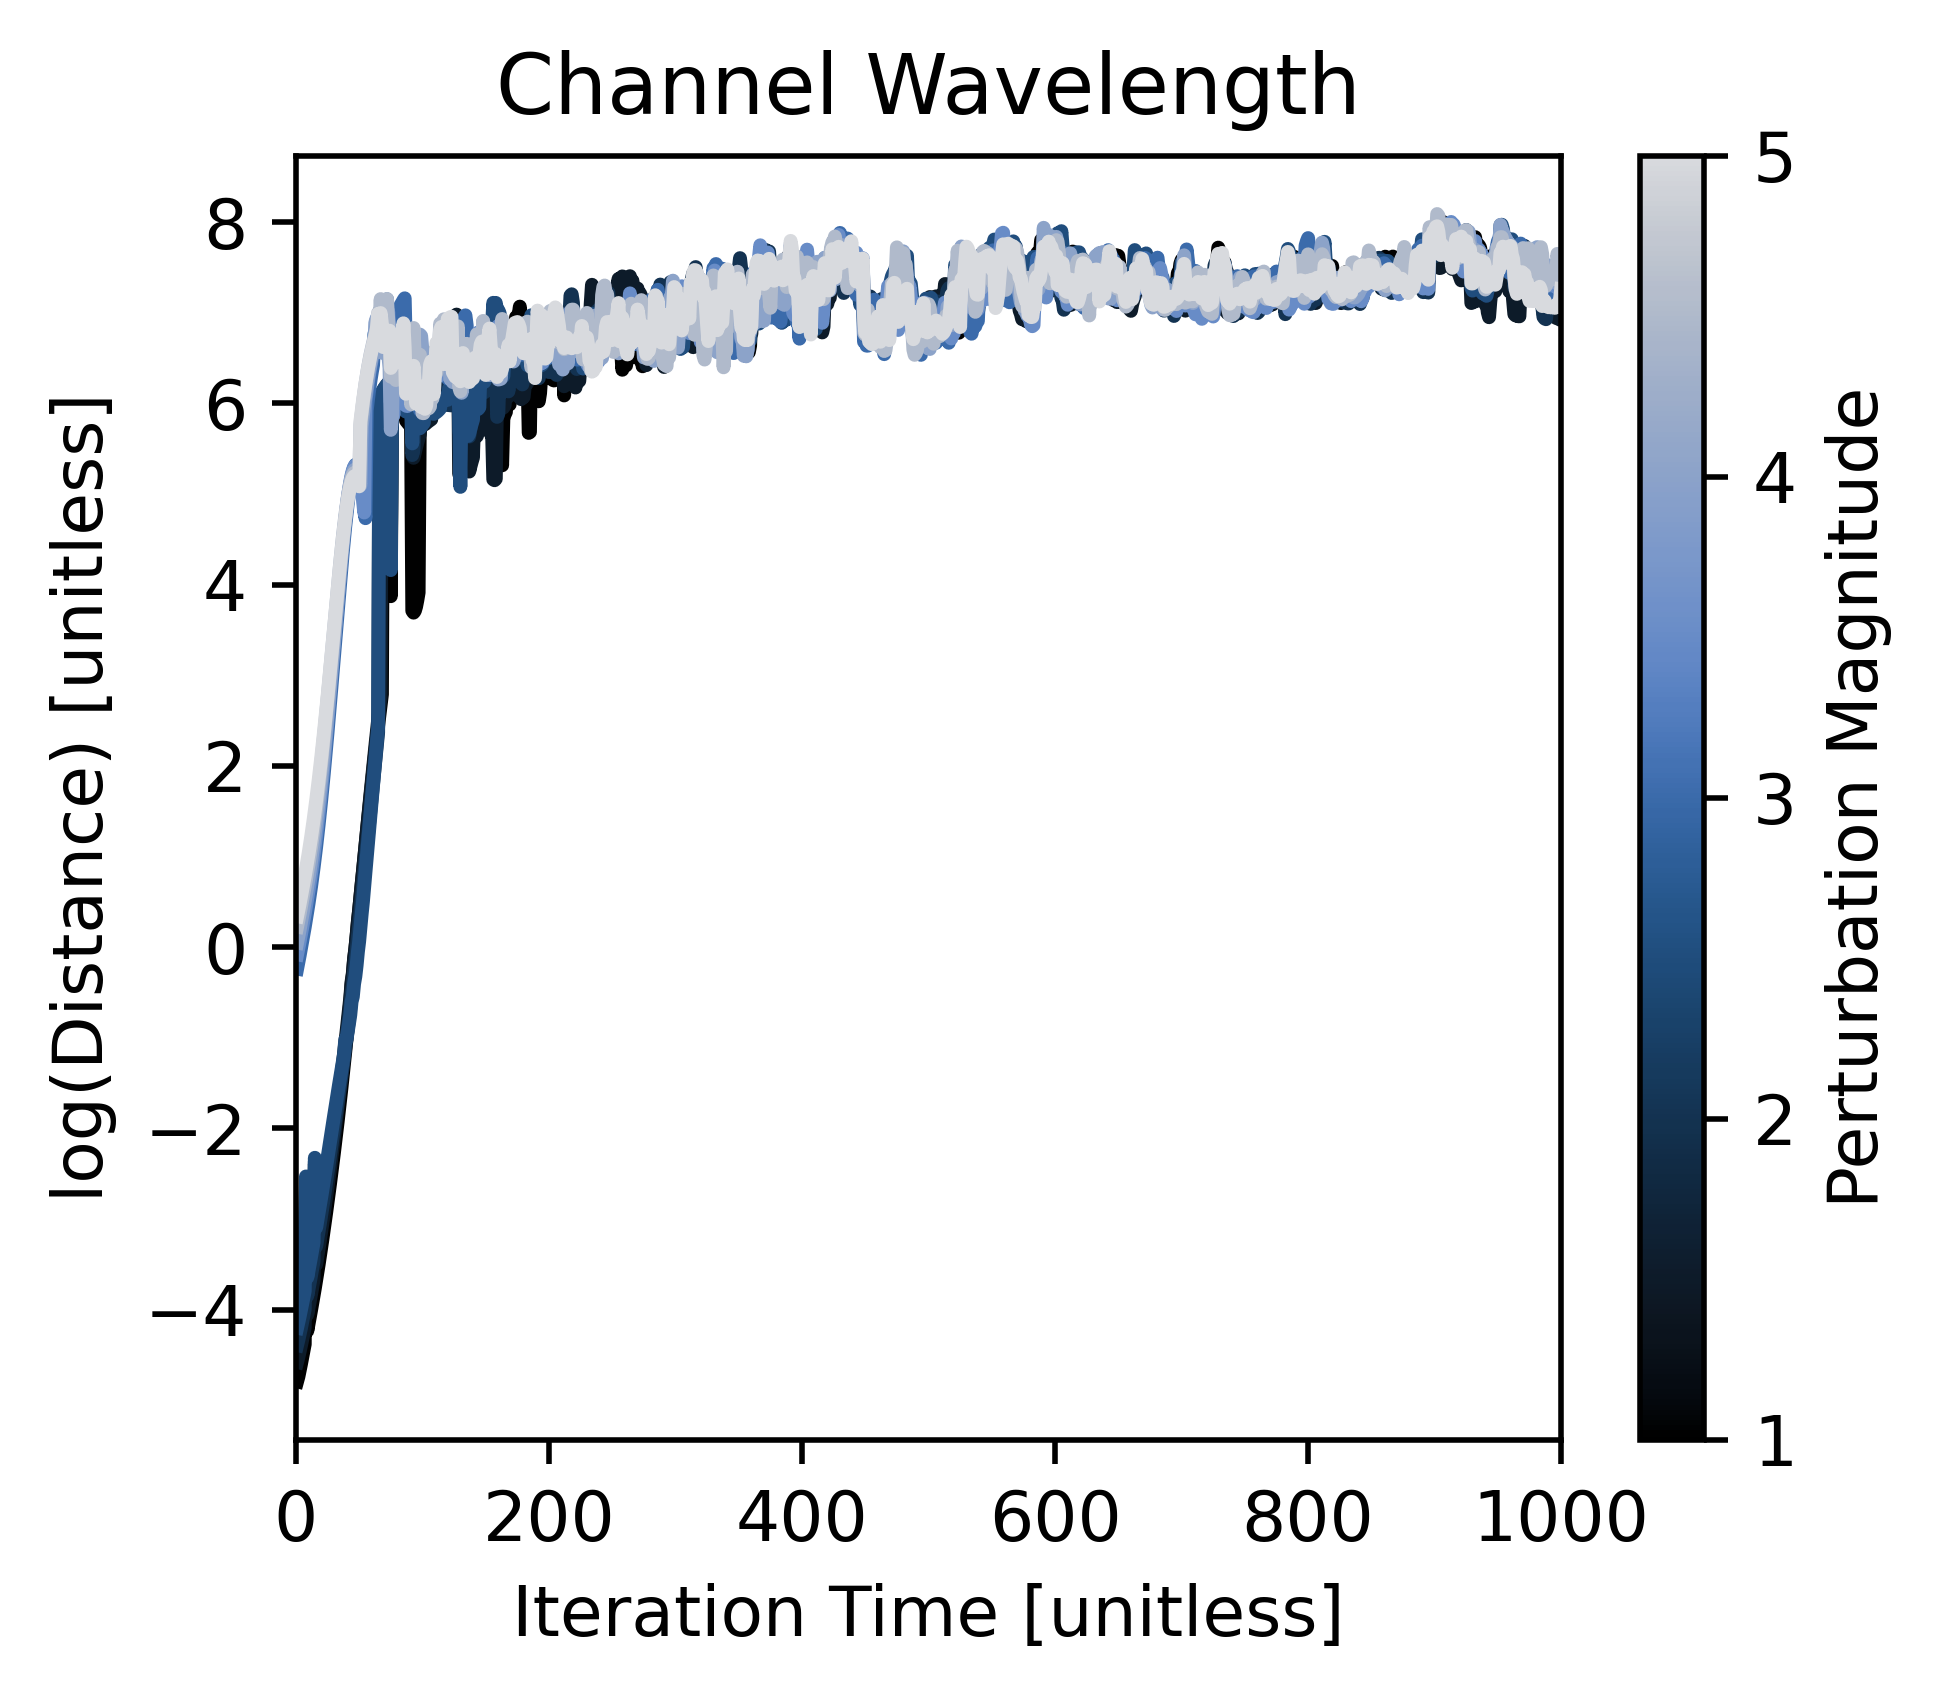

In [117]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors

# Create a shifted version of the Oslo colormap by sampling from 0 to 0.90
cmap_original = cmc.oslo
shifted_colors = cmap_original(np.linspace(0, 0.90, 256))
shifted_oslo = mcolors.LinearSegmentedColormap.from_list("shifted_oslo", shifted_colors)

# Get all saved files in the directory
file_paths = sorted(glob.glob("/Users/braydennoh/Documents/phasespace/2.18/cutoffbig/t_d_valid_freq_*.txt"))

# Define normalization based on the new perturbation range (1 to 5)
norm = plt.Normalize(vmin=1, vmax=5)

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 3.5))

# Loop through each file, extract the perturbation value, and plot
for file_path in file_paths:
    match = re.search(r"t_d_valid_freq_([\d\.Ee+-]+)\.txt", file_path)
    if match:
        perturbation_value = float(match.group(1))
        data = np.loadtxt(file_path)

        # If data is 1D and has 2 elements, reshape it
        if data.ndim == 1 and data.size == 2:
            data = data.reshape(1, 2)
        if data.ndim < 2 or data.shape[1] < 2:
            continue


        color = shifted_oslo(norm(perturbation_value))
        ax.plot(data[:, 0], np.log(data[:, 1]), color=color, lw=2, label=f"{perturbation_value:.1f}")

# Create a manual colorbar with ticks at 1, 2, 3, 4, and 5
cbar_ticks = [1, 2, 3, 4, 5]
sm = plt.cm.ScalarMappable(cmap=shifted_oslo, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=cbar_ticks)
cbar.set_label("Perturbation Magnitude")
cbar.ax.set_yticklabels([str(tick) for tick in cbar_ticks])

ax.set_xlabel("Iteration Time [unitless]")
ax.set_ylabel("log(Distance) [unitless]")  # Assuming units are not defined
ax.set_title("Channel Wavelength")
ax.set_xlim([0, 1000])

plt.tight_layout()
plt.show()